Alzheimer MRI Disease Classification
This notebook is my first time using PyTorch, I usually work with TensorFlow. Therefore, it should serve as a nice resource for those of you just starting with deep learning or PyTorch.

The aim of this task is to classify if a patient, and if so to what degree, has Alzheimers disease using an MRI scan of the patient brain. In total we are predicting one of four classes those being:

Non demented
Very midly demented
Mildly demented
Moderately demented.


In [1]:
!pip install torch torchvision
!pip install scikit-learn
!pip install torchinfo
!pip install tqdm
!pip install opencv-python
!pip install matplotlib
!pip install pillow
!pip install Pillow numpy matplotlib
!pip install torchinfo


In [2]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import zipfile
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import gc
import cv2
import pandas as pd
import time 
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

In [3]:

print("¿CUDA disponible?:", torch.cuda.is_available())
print("Nombre de la GPU:", torch.cuda.get_device_name(0))
print("Número de dispositivos CUDA:", torch.cuda.device_count())


¿CUDA disponible?: True
Nombre de la GPU: NVIDIA TITAN RTX
Número de dispositivos CUDA: 7


In [4]:
from torch.utils.data import Dataset
import torch

# Custom MRI dataset class for handling images and masks
class MRIDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images  # List or tensor of images
        self.masks = masks    # List or tensor of corresponding masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Return a single image and its corresponding mask
        return self.images[idx], self.masks[idx]


In [5]:
import os
import numpy as np
from PIL import Image
import zipfile
import torch

# Extract dataset (adjust the filename if needed)
with zipfile.ZipFile("lgg-mri-segmentation.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

data_path = "./data"

# Function to load data
def load_data(data_path):
    images = []
    masks = []

    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('mask.tif'):
                mask_path = os.path.join(root, file)
                image_path = mask_path.replace('_mask.tif', '.tif')

                # Check if the files exist
                if not os.path.exists(image_path):
                    print(f"Image not found: {image_path}")
                    continue

                if not os.path.exists(mask_path):
                    print(f"Mask not found: {mask_path}")
                    continue

                try:
                    # Load the images and masks
                    image = np.array(Image.open(image_path).convert('L')) / 255.0  # Normalize image
                    mask = (np.array(Image.open(mask_path).convert('L')) > 0).astype(np.float32)  # Binary mask

                    images.append(image)
                    masks.append(mask)
                except Exception as e:
                    print(f"Error loading files: {e}")

    print(f"Total images: {len(images)}")
    print(f"Total masks: {len(masks)}")
    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_data(data_path)

# Check if data is empty
if len(images) == 0 or len(masks) == 0:
    raise ValueError("No images or masks loaded. Check the dataset path.")

# Add color channel (for grayscale images)
images = images[:, np.newaxis, :, :]  # Add new dimension for channel
masks = masks[:, np.newaxis, :, :]

# Convert to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
masks = torch.tensor(masks, dtype=torch.float32)

print(f"Image dimensions: {images.shape}")
print(f"Mask dimensions: {masks.shape}")


Total images: 7858
Total masks: 7858
Image dimensions: torch.Size([7858, 1, 256, 256])
Mask dimensions: torch.Size([7858, 1, 256, 256])


In [6]:
from sklearn.model_selection import train_test_split

# Split into training, validation, and test sets (e.g., 80/10/10 split)
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")
print(f"Test images: {test_images.shape}")


Training images: torch.Size([5028, 1, 256, 256])
Validation images: torch.Size([1258, 1, 256, 256])
Test images: torch.Size([1572, 1, 256, 256])


In [7]:
from torch.utils.data import Dataset, DataLoader

# Custom MRI dataset
class MRIDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

# Create the datasets and dataloaders
train_dataset = MRIDataset(train_images, train_masks)
val_dataset = MRIDataset(val_images, val_masks)
test_dataset = MRIDataset(test_images, test_masks)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training dataset size: {len(train_loader)}")
print(f"Validation dataset size: {len(val_loader)}")
print(f"Testing dataset size: {len(test_loader)}")


Training dataset size: 158
Validation dataset size: 40
Testing dataset size: 197


In [8]:


with zipfile.ZipFile("lgg-mri-segmentation.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")


In [9]:
data_path = "./data"


In [10]:

print("Archivos en el directorio:")
for root, dirs, files in os.walk(data_path):
    print(f"Directorio: {root}, Archivos: {len(files)}")
    for file in files[:5]:  # Mostrar los primeros 5 archivos
        print(file)


Archivos en el directorio:
Directorio: ./data, Archivos: 0
Directorio: ./data/kaggle_3m, Archivos: 2
data.csv
README.md
Directorio: ./data/kaggle_3m/TCGA_DU_7018_19911220, Archivos: 72
TCGA_DU_7018_19911220_1_mask.tif
TCGA_DU_7018_19911220_21.tif
TCGA_DU_7018_19911220_24.tif
TCGA_DU_7018_19911220_25_mask.tif
TCGA_DU_7018_19911220_26_mask.tif
Directorio: ./data/kaggle_3m/TCGA_HT_8105_19980826, Archivos: 64
TCGA_HT_8105_19980826_3.tif
TCGA_HT_8105_19980826_11.tif
TCGA_HT_8105_19980826_15_mask.tif
TCGA_HT_8105_19980826_9_mask.tif
TCGA_HT_8105_19980826_4.tif
Directorio: ./data/kaggle_3m/TCGA_CS_6667_20011105, Archivos: 40
TCGA_CS_6667_20011105_17.tif
TCGA_CS_6667_20011105_4_mask.tif
TCGA_CS_6667_20011105_8_mask.tif
TCGA_CS_6667_20011105_8.tif
TCGA_CS_6667_20011105_14_mask.tif
Directorio: ./data/kaggle_3m/TCGA_DU_5872_19950223, Archivos: 142
TCGA_DU_5872_19950223_55.tif
TCGA_DU_5872_19950223_31.tif
TCGA_DU_5872_19950223_28.tif
TCGA_DU_5872_19950223_17_mask.tif
TCGA_DU_5872_19950223_35.tif
D

In [11]:
for root, dirs, files in os.walk(data_path):
    print(f"Directorio: {root}, Archivos encontrados: {len(files)}")


Directorio: ./data, Archivos encontrados: 0
Directorio: ./data/kaggle_3m, Archivos encontrados: 2
Directorio: ./data/kaggle_3m/TCGA_DU_7018_19911220, Archivos encontrados: 72
Directorio: ./data/kaggle_3m/TCGA_HT_8105_19980826, Archivos encontrados: 64
Directorio: ./data/kaggle_3m/TCGA_CS_6667_20011105, Archivos encontrados: 40
Directorio: ./data/kaggle_3m/TCGA_DU_5872_19950223, Archivos encontrados: 142
Directorio: ./data/kaggle_3m/TCGA_HT_7692_19960724, Archivos encontrados: 40
Directorio: ./data/kaggle_3m/TCGA_DU_7304_19930325, Archivos encontrados: 72
Directorio: ./data/kaggle_3m/TCGA_DU_8162_19961029, Archivos encontrados: 74
Directorio: ./data/kaggle_3m/TCGA_DU_5855_19951217, Archivos encontrados: 52
Directorio: ./data/kaggle_3m/TCGA_DU_7008_19830723, Archivos encontrados: 104
Directorio: ./data/kaggle_3m/TCGA_DU_7019_19940908, Archivos encontrados: 76
Directorio: ./data/kaggle_3m/TCGA_HT_7605_19950916, Archivos encontrados: 64
Directorio: ./data/kaggle_3m/TCGA_DU_7299_19910417, A

In [12]:
# Define the U-Net model (or any other model)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        # Example layers for the U-Net model
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the correct device (GPU or CPU)
model = UNet().to(device)

# Print the current device and check if the model is on the GPU
print("Current device:", device)
print("Is the model on GPU?:", next(model.parameters()).is_cuda)

Current device: cuda
Is the model on GPU?: True


In [13]:

def load_data(data_path):
    images = []
    masks = []

    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('mask.tif'):
                mask_path = os.path.join(root, file)
                image_path = mask_path.replace('_mask.tif', '.tif')

                # Verificar si los archivos existen
                if not os.path.exists(image_path):
                    print(f"Imagen no encontrada: {image_path}")
                    continue

                if not os.path.exists(mask_path):
                    print(f"Máscara no encontrada: {mask_path}")
                    continue

                try:
                    # Cargar las imágenes
                    image = np.array(Image.open(image_path).convert('L')) / 255.0
                    mask = (np.array(Image.open(mask_path).convert('L')) > 0).astype(np.float32)

                    images.append(image)
                    masks.append(mask)
                except Exception as e:
                    print(f"Error al cargar los archivos: {e}")

    print(f"Total de imágenes: {len(images)}")
    print(f"Total de máscaras: {len(masks)}")
    return np.array(images), np.array(masks)


In [14]:
images, masks = load_data(data_path)

# Verificar si los datos están vacíos
if len(images) == 0 or len(masks) == 0:
    raise ValueError("No se cargaron imágenes o máscaras. Verifica la ruta del dataset.")

# Mostrar las dimensiones de los datos
print(f"Dimensiones de las imágenes: {images.shape}")
print(f"Dimensiones de las máscaras: {masks.shape}")


Total de imágenes: 7858
Total de máscaras: 7858
Dimensiones de las imágenes: (7858, 256, 256)
Dimensiones de las máscaras: (7858, 256, 256)


In [15]:


# Añadir canal de color
images = images[:, np.newaxis, :, :]  # Nueva dimensión para el canal
masks = masks[:, np.newaxis, :, :]

print(f"Nuevo tamaño de las imágenes: {images.shape}")
print(f"Nuevo tamaño de las máscaras: {masks.shape}")


Nuevo tamaño de las imágenes: (7858, 1, 256, 256)
Nuevo tamaño de las máscaras: (7858, 1, 256, 256)


In [16]:
images = torch.tensor(images, dtype=torch.float32)
masks = torch.tensor(masks, dtype=torch.float32)


In [17]:


total_train_images, test_images, total_train_masks, test_masks = train_test_split( 
    images, masks, test_size=0.2, random_state=42
)

train_images, val_images, train_masks, val_masks = train_test_split(
    total_train_images, total_train_masks, test_size=0.2, random_state=42
)


print(f"Imágenes de entrenamiento: {train_images.shape}")
print(f"Máscaras de entrenamiento: {train_masks.shape}")
print(f"Imágenes de validación: {val_images.shape}")
print(f"Máscaras de validación: {val_masks.shape}")


Imágenes de entrenamiento: torch.Size([5028, 1, 256, 256])
Máscaras de entrenamiento: torch.Size([5028, 1, 256, 256])
Imágenes de validación: torch.Size([1258, 1, 256, 256])
Máscaras de validación: torch.Size([1258, 1, 256, 256])


In [18]:

class MRIDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]


In [19]:

batch_size = 32

train_dataset = MRIDataset(train_images, train_masks)
val_dataset = MRIDataset(val_images, val_masks)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'tamano del dataset de entrenamiento: {train_dataset.__len__()}')
print(f'tamano del dataset de validacion: {val_dataset.__len__()}')
# print(f"Tamaño del DataLoader de entrenamiento: {len(train_loader)}")
# print(f"Tamaño del DataLoader de validación: {len(val_loader)}")


tamano del dataset de entrenamiento: 5028
tamano del dataset de validacion: 1258


In [20]:


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bridge = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool(e1))
        e3 = self.encoder3(self.pool(e2))
        e4 = self.encoder4(self.pool(e3))

        b = self.bridge(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.decoder4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.decoder3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.decoder2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.decoder1(d1)

        output = torch.sigmoid(self.output_layer(d1))
        return output


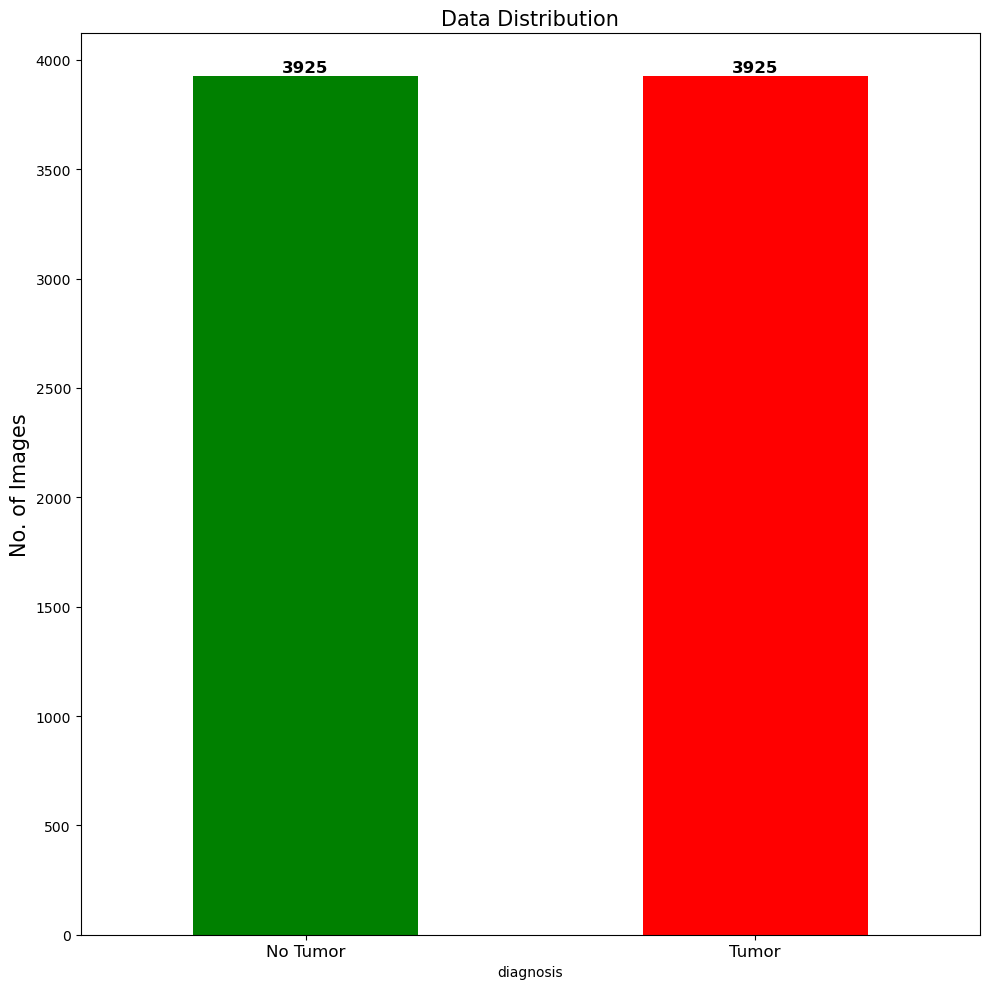

In [21]:
# Example list of diagnosis labels (You can replace this with actual data)
# This should match the number of images you have in your dataset.
# Example: 0 for 'No Tumor', 1 for 'Tumor'
diagnosis_labels = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0] * 785  # Just for example to match your dataset size (7858 images)

# Convert the labels to a DataFrame
df = pd.DataFrame({'diagnosis': diagnosis_labels})

# Plotting the distribution
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10, 10), color=['green', 'red'])
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_title('Data Distribution', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)

# Annotate the count on top of each bar
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows + 20), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

Total images: 7858
Total masks: 7858
Image dimensions: (7858, 256, 256)
Mask dimensions: (7858, 256, 256)


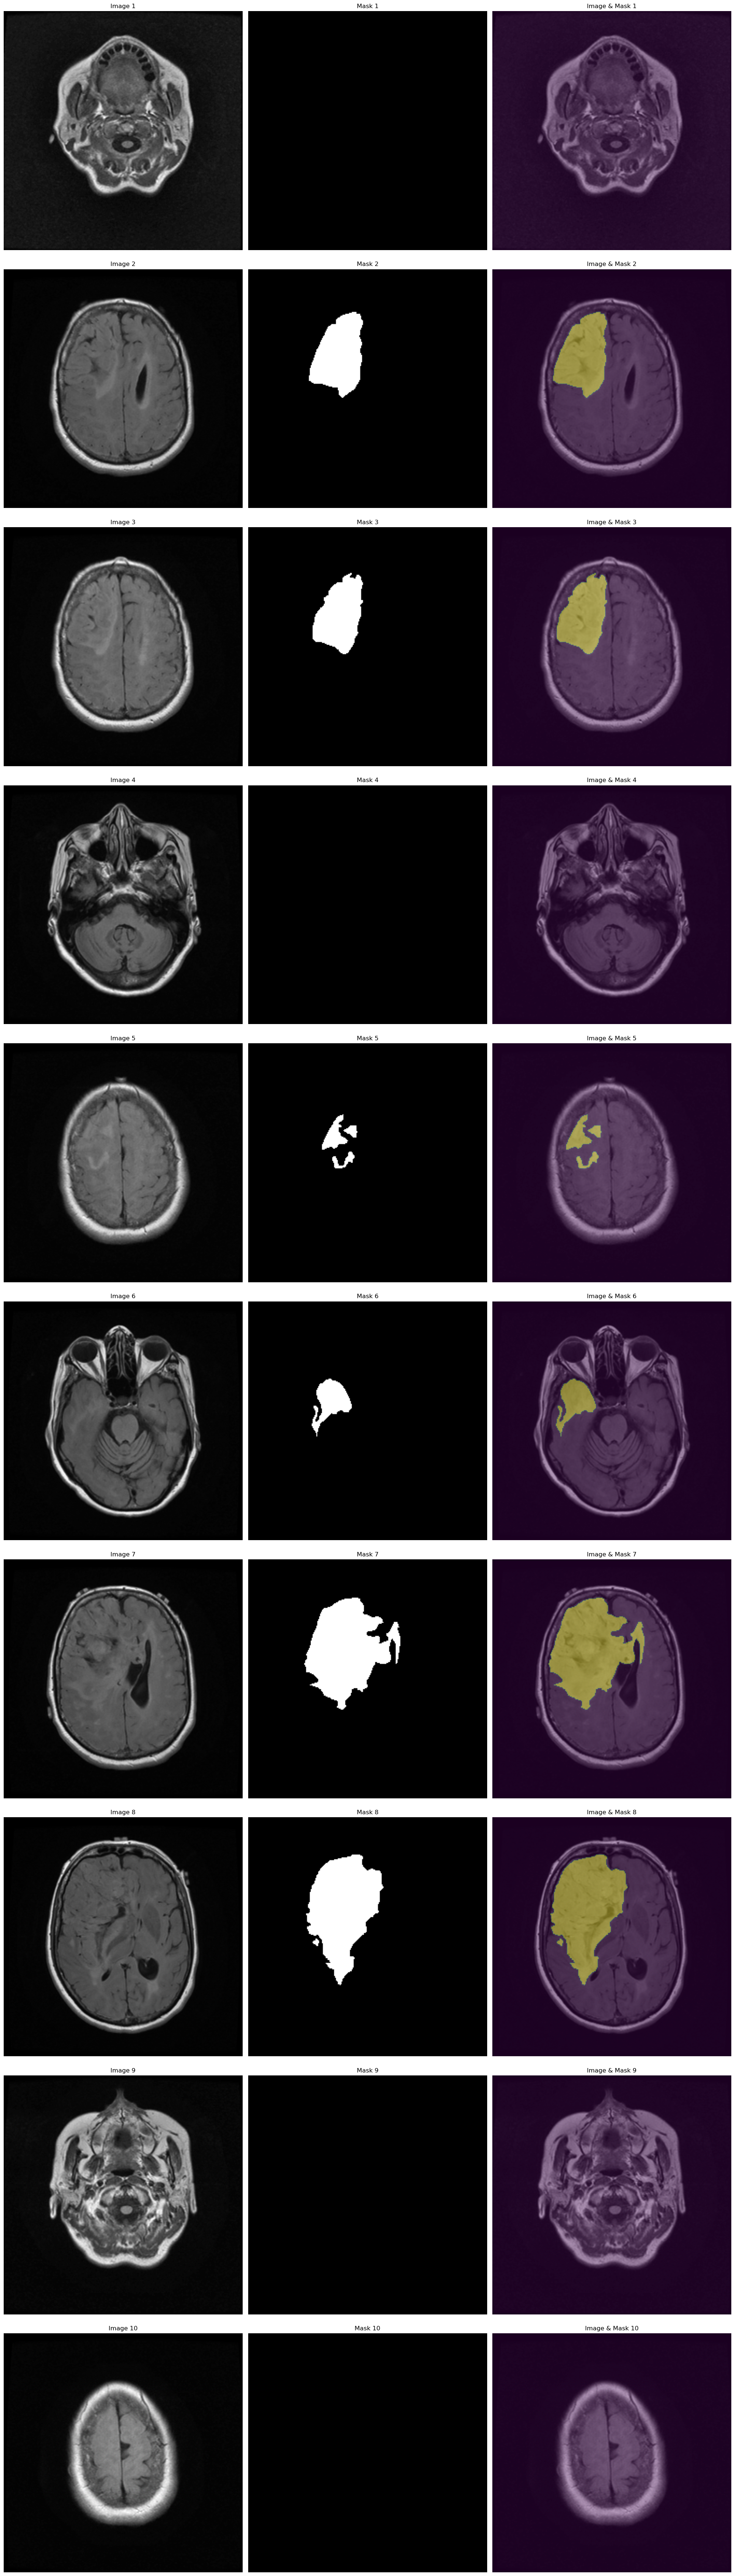

In [22]:

# Extract dataset
with zipfile.ZipFile("lgg-mri-segmentation.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

data_path = "./data"

# Function to load data
def load_data(data_path):
    images = []
    masks = []

    for root, _, files in os.walk(data_path):
        for file in files:
            if file.endswith('mask.tif'):
                mask_path = os.path.join(root, file)
                image_path = mask_path.replace('_mask.tif', '.tif')

                # Check if the files exist
                if not os.path.exists(image_path):
                    print(f"Image not found: {image_path}")
                    continue

                if not os.path.exists(mask_path):
                    print(f"Mask not found: {mask_path}")
                    continue

                try:
                    # Load the images
                    image = np.array(Image.open(image_path).convert('L')) / 255.0
                    mask = (np.array(Image.open(mask_path).convert('L')) > 0).astype(np.float32)

                    images.append(image)
                    masks.append(mask)
                except Exception as e:
                    print(f"Error loading files: {e}")

    print(f"Total images: {len(images)}")
    print(f"Total masks: {len(masks)}")
    return np.array(images), np.array(masks)

# Load data
images, masks = load_data(data_path)

# Check if data is empty
if len(images) == 0 or len(masks) == 0:
    raise ValueError("No images or masks loaded. Check the dataset path.")

print(f"Image dimensions: {images.shape}")
print(f"Mask dimensions: {masks.shape}")

# Add color channel (for grayscale images)
images = images[:, np.newaxis, :, :]  # Add new dimension for channel
masks = masks[:, np.newaxis, :, :]

# Convert to PyTorch tensors
images = torch.tensor(images, dtype=torch.float32)
masks = torch.tensor(masks, dtype=torch.float32)

# Function to visualize multiple samples (10 images and their masks)
def visualize_multiple_images_and_masks(num_images=10):
    fig, axs = plt.subplots(num_images, 3, figsize=(20, 7 * num_images))
    
    for i in range(num_images):
        # Get the image and mask for the current index
        image = images[i].squeeze()  # Squeeze to remove unnecessary dimensions (e.g., channel dimension)
        mask = masks[i].squeeze()

        # Plot the image
        axs[i, 0].imshow(image, cmap='gray')
        axs[i, 0].set_title(f"Image {i+1}")
        axs[i, 0].axis('off')

        # Plot the mask
        axs[i, 1].imshow(mask, cmap='gray')
        axs[i, 1].set_title(f"Mask {i+1}")
        axs[i, 1].axis('off')

        # Plot the overlay of image and mask
        axs[i, 2].imshow(image, cmap='gray')
        axs[i, 2].imshow(mask, alpha=0.4)  # Overlay mask on top of image with transparency
        axs[i, 2].set_title(f"Image & Mask {i+1}")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first 10 sample images and their masks
visualize_multiple_images_and_masks(num_images=10)

In [23]:
# Verificar si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando el dispositivo: {device}")

# Crear el modelo y moverlo al dispositivo (CPU o GPU)
model = UNet().to(device)

# Configurar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Modelo U-Net creado y movido al dispositivo:", device)


Usando el dispositivo: cuda
Modelo U-Net creado y movido al dispositivo: cuda


In [24]:
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [25]:
def dice_loss(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Configurar el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [27]:
images = images.to(device, non_blocking=True)
masks = masks.to(device, non_blocking=True)


In [28]:
train_dataset.__getitem__(3000)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]))

In [29]:
model = model.to(device)
images, masks = images.to(device), masks.to(device)


In [30]:

class TimeoutError(Exception):
    """Custom exception for timeout."""
    pass

def train_one_epoch(model, train_loader, optimizer, device, max_batch_time=30):
    """
    Entrenamiento por una única época con límite de tiempo por lote.
    """
    model.train()
    train_loss = 0
    all_preds = []
    all_targets = []

    for i, (images, masks) in enumerate(tqdm(train_loader, desc="Training")):
        # Establecer el temporizador por lote
        batch_start_time = time.time()

        # Mover datos a la GPU
        images, masks = images.to(device), masks.to(device)

        # Forward y cálculo de pérdida
        outputs = model(images)
        loss = dice_loss(outputs, masks)

        # Backward y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Obtener predicciones y almacenar
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(masks.cpu().numpy().flatten())

        # Liberar memoria para evitar fugas
        del images, masks, outputs, preds
        torch.cuda.empty_cache()

        # Verificar si el lote ha excedido el tiempo máximo permitido
        batch_duration = time.time() - batch_start_time
        if batch_duration > max_batch_time:
            raise TimeoutError(f"Batch {i+1} exceeded the maximum allowed time of {max_batch_time} seconds.")

    avg_train_loss = train_loss / len(train_loader)

    # Convertir listas a numpy arrays y calcular precisión
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    train_accuracy = np.sum(all_targets == all_preds) / len(all_targets)

    # Reducir el tamaño para cálculo de F1 score si los datos son demasiado grandes
    if len(all_targets) > 10000:
        idx = np.random.choice(len(all_targets), 10000, replace=False)  # Tomar muestra de 10,000 elementos
        subset_targets = all_targets[idx]
        subset_preds = all_preds[idx]
    else:
        subset_targets = all_targets
        subset_preds = all_preds

    train_f1 = f1_score(subset_targets, subset_preds, average='binary')

    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1: {train_f1:.4f}")
    return avg_train_loss, train_accuracy, train_f1


def validate_one_epoch(model, val_loader, device):
    """
    Validación por una única época.
    """
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(val_loader, desc="Validation", leave=True)):
            # Mover datos a la GPU
            images, masks = images.to(device), masks.to(device)

            # Forward
            outputs = model(images)
            loss = dice_loss(outputs, masks)

            val_loss += loss.item()

            # Obtener predicciones y almacenar
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_targets.extend(masks.cpu().numpy().flatten())

            # Liberar memoria
            del images, masks, outputs, preds
            torch.cuda.empty_cache()

    # Convertir listas a numpy arrays y calcular precisión
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = np.sum(all_targets == all_preds) / len(all_targets)

    # Reducir el tamaño para cálculo de F1 score si los datos son demasiado grandes
    if len(all_targets) > 10000:
        idx = np.random.choice(len(all_targets), 10000, replace=False)  # Tomar muestra de 10,000 elementos
        subset_targets = all_targets[idx]
        subset_preds = all_preds[idx]
    else:
        subset_targets = all_targets
        subset_preds = all_preds

    val_f1 = f1_score(subset_targets, subset_preds, average='binary')

    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1: {val_f1:.4f}")
    return avg_val_loss, val_accuracy, val_f1


def train(model, train_loader, val_loader, optimizer, epochs=10, max_epoch_time=300, max_batch_time=30):
    """
    Entrenamiento y validación del modelo con límite de tiempo por época y lote.
    """
    history = {
        'train_loss': [], 'val_loss': [],
        'train_accuracy': [], 'val_accuracy': [],
        'train_f1': [], 'val_f1': []
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_save_path = "/home/feralonso/UNet_gliomas.pth"
    model.to(device)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        
        # Medir el tiempo de la época
        epoch_start_time = time.time()
        
        try:
            # Entrenamiento de una época
            avg_train_loss, train_accuracy, train_f1 = train_one_epoch(model, train_loader, optimizer, device, max_batch_time)
            history['train_loss'].append(avg_train_loss)
            history['train_accuracy'].append(train_accuracy)
            history['train_f1'].append(train_f1)

            # Verificar si la época ha excedido el tiempo límite
            epoch_duration = time.time() - epoch_start_time
            if epoch_duration > max_epoch_time:
                raise TimeoutError(f"Epoch {epoch + 1} exceeded the maximum allowed time of {max_epoch_time} seconds.")

            # Validación de una época
            avg_val_loss, val_accuracy, val_f1 = validate_one_epoch(model, val_loader, device)
            history['val_loss'].append(avg_val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_f1'].append(val_f1)

        except TimeoutError as e:
            print(f"TimeoutError: {e}")
            break

        # Limpiar memoria después de cada epoch
        gc.collect()
        torch.cuda.empty_cache()

# Guardar el modelo al final de todas las épocas
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo guardado en: {model_save_path}")    

    return history

# Luego puedes ejecutar el entrenamiento
# history = train(model, train_loader, val_loader, optimizer, epochs=10)



In [31]:

# Configuración de DataLoader con batch_size de 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# Entrenar el modelo con timeout por época y lote
try:
    history = train(model, train_loader, val_loader, optimizer, epochs=20, max_epoch_time=300, max_batch_time=30)
except TimeoutError as e:
    print(f"TimeoutError: {e}")

# Imprimir el F1 Score y otras métricas
print(history['train_f1'])  # F1 Score de entrenamiento por época
print(history['val_f1'])    # F1 Score de validación por época


Epoch 1/20


Training: 100%|███████████████████████████████| 158/158 [02:11<00:00,  1.21it/s]


Train Loss: 0.9479, Train Accuracy: 0.8365, Train F1: 0.0971


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.34it/s]


Val Loss: 0.9415, Val Accuracy: 0.8665, Val F1: 0.1446

Epoch 2/20


Training: 100%|███████████████████████████████| 158/158 [02:11<00:00,  1.20it/s]


Train Loss: 0.9278, Train Accuracy: 0.9348, Train F1: 0.2098


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.32it/s]


Val Loss: 0.9193, Val Accuracy: 0.9170, Val F1: 0.1911

Epoch 3/20


Training: 100%|███████████████████████████████| 158/158 [02:07<00:00,  1.23it/s]


Train Loss: 0.9000, Train Accuracy: 0.9642, Train F1: 0.3099


Validation: 100%|███████████████████████████████| 40/40 [00:18<00:00,  2.13it/s]


Val Loss: 0.8925, Val Accuracy: 0.9899, Val F1: 0.6234

Epoch 4/20


Training: 100%|███████████████████████████████| 158/158 [02:11<00:00,  1.20it/s]


Train Loss: 0.8561, Train Accuracy: 0.9787, Train F1: 0.4795


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.25it/s]


Val Loss: 0.8275, Val Accuracy: 0.9880, Val F1: 0.5811

Epoch 5/20


Training: 100%|███████████████████████████████| 158/158 [02:17<00:00,  1.15it/s]


Train Loss: 0.7769, Train Accuracy: 0.9873, Train F1: 0.6053


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.28it/s]


Val Loss: 0.7412, Val Accuracy: 0.9838, Val F1: 0.6005

Epoch 6/20


Training: 100%|███████████████████████████████| 158/158 [02:08<00:00,  1.23it/s]


Train Loss: 0.6680, Train Accuracy: 0.9916, Train F1: 0.6774


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.26it/s]


Val Loss: 0.6044, Val Accuracy: 0.9942, Val F1: 0.7649

Epoch 7/20


Training: 100%|███████████████████████████████| 158/158 [02:15<00:00,  1.16it/s]


Train Loss: 0.5249, Train Accuracy: 0.9944, Train F1: 0.7246


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.28it/s]


Val Loss: 0.4602, Val Accuracy: 0.9956, Val F1: 0.8130

Epoch 8/20


Training: 100%|███████████████████████████████| 158/158 [02:11<00:00,  1.20it/s]


Train Loss: 0.3978, Train Accuracy: 0.9958, Train F1: 0.7850


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.29it/s]


Val Loss: 0.3698, Val Accuracy: 0.9966, Val F1: 0.7835

Epoch 9/20


Training: 100%|███████████████████████████████| 158/158 [02:13<00:00,  1.18it/s]


Train Loss: 0.3076, Train Accuracy: 0.9964, Train F1: 0.8387


Validation: 100%|███████████████████████████████| 40/40 [00:18<00:00,  2.11it/s]


Val Loss: 0.3136, Val Accuracy: 0.9966, Val F1: 0.8276

Epoch 10/20


Training: 100%|███████████████████████████████| 158/158 [02:17<00:00,  1.15it/s]


Train Loss: 0.2502, Train Accuracy: 0.9966, Train F1: 0.7664


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.24it/s]


Val Loss: 0.2244, Val Accuracy: 0.9970, Val F1: 0.8333

Epoch 11/20


Training: 100%|███████████████████████████████| 158/158 [02:12<00:00,  1.19it/s]


Train Loss: 0.2034, Train Accuracy: 0.9972, Train F1: 0.8934


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.28it/s]


Val Loss: 0.1984, Val Accuracy: 0.9968, Val F1: 0.8792

Epoch 12/20


Training: 100%|███████████████████████████████| 158/158 [02:13<00:00,  1.18it/s]


Train Loss: 0.1781, Train Accuracy: 0.9973, Train F1: 0.8868


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.27it/s]


Val Loss: 0.1904, Val Accuracy: 0.9966, Val F1: 0.8309

Epoch 13/20


Training: 100%|███████████████████████████████| 158/158 [02:10<00:00,  1.21it/s]


Train Loss: 0.1701, Train Accuracy: 0.9973, Train F1: 0.8287


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.26it/s]


Val Loss: 0.1760, Val Accuracy: 0.9974, Val F1: 0.8947

Epoch 14/20


Training: 100%|███████████████████████████████| 158/158 [02:19<00:00,  1.13it/s]


Train Loss: 0.1597, Train Accuracy: 0.9974, Train F1: 0.8087


Validation: 100%|███████████████████████████████| 40/40 [00:18<00:00,  2.20it/s]


Val Loss: 0.1518, Val Accuracy: 0.9976, Val F1: 0.8796

Epoch 15/20


Training: 100%|███████████████████████████████| 158/158 [02:11<00:00,  1.20it/s]


Train Loss: 0.1586, Train Accuracy: 0.9974, Train F1: 0.9000


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.28it/s]


Val Loss: 0.1631, Val Accuracy: 0.9973, Val F1: 0.8941

Epoch 16/20


Training: 100%|███████████████████████████████| 158/158 [02:17<00:00,  1.15it/s]


Train Loss: 0.1398, Train Accuracy: 0.9977, Train F1: 0.8626


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.25it/s]


Val Loss: 0.1507, Val Accuracy: 0.9973, Val F1: 0.8404

Epoch 17/20


Training: 100%|███████████████████████████████| 158/158 [02:12<00:00,  1.19it/s]


Train Loss: 0.1457, Train Accuracy: 0.9975, Train F1: 0.8696


Validation: 100%|███████████████████████████████| 40/40 [00:20<00:00,  1.92it/s]


Val Loss: 0.1522, Val Accuracy: 0.9973, Val F1: 0.9009

Epoch 18/20


Training: 100%|███████████████████████████████| 158/158 [02:15<00:00,  1.17it/s]


Train Loss: 0.1352, Train Accuracy: 0.9976, Train F1: 0.8727


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.29it/s]


Val Loss: 0.1385, Val Accuracy: 0.9976, Val F1: 0.8308

Epoch 19/20


Training: 100%|███████████████████████████████| 158/158 [02:17<00:00,  1.15it/s]


Train Loss: 0.1281, Train Accuracy: 0.9978, Train F1: 0.8900


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.27it/s]


Val Loss: 0.1287, Val Accuracy: 0.9976, Val F1: 0.8692

Epoch 20/20


Training: 100%|███████████████████████████████| 158/158 [02:09<00:00,  1.22it/s]


Train Loss: 0.1186, Train Accuracy: 0.9979, Train F1: 0.8974


Validation: 100%|███████████████████████████████| 40/40 [00:17<00:00,  2.28it/s]


Val Loss: 0.1302, Val Accuracy: 0.9977, Val F1: 0.8792
Modelo guardado en: /home/feralonso/UNet_gliomas.pth
[0.09711846318036287, 0.2097902097902098, 0.30991735537190085, 0.4794520547945205, 0.6052631578947368, 0.6774193548387096, 0.7246376811594203, 0.7850467289719626, 0.8387096774193549, 0.7663551401869159, 0.8934010152284264, 0.8867924528301887, 0.8287292817679558, 0.8087431693989071, 0.9, 0.8625592417061612, 0.8695652173913043, 0.8727272727272727, 0.8899521531100478, 0.8974358974358975]
[0.1445929526123937, 0.19113300492610838, 0.6233766233766234, 0.5811320754716981, 0.6005221932114883, 0.7649402390438247, 0.8130081300813008, 0.7835051546391752, 0.8275862068965517, 0.8333333333333334, 0.8792270531400966, 0.8309178743961353, 0.8947368421052632, 0.8796296296296297, 0.8941176470588236, 0.8404255319148937, 0.9009009009009009, 0.8307692307692308, 0.8691588785046729, 0.8792270531400966]


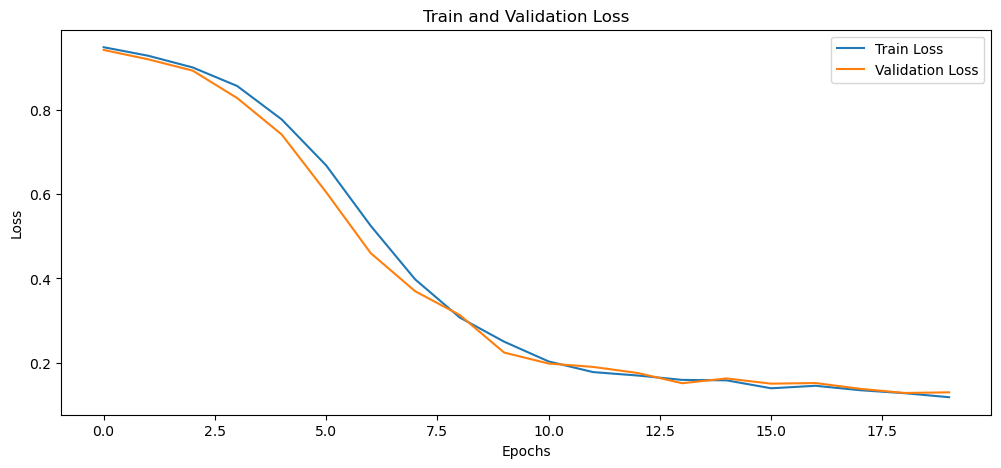

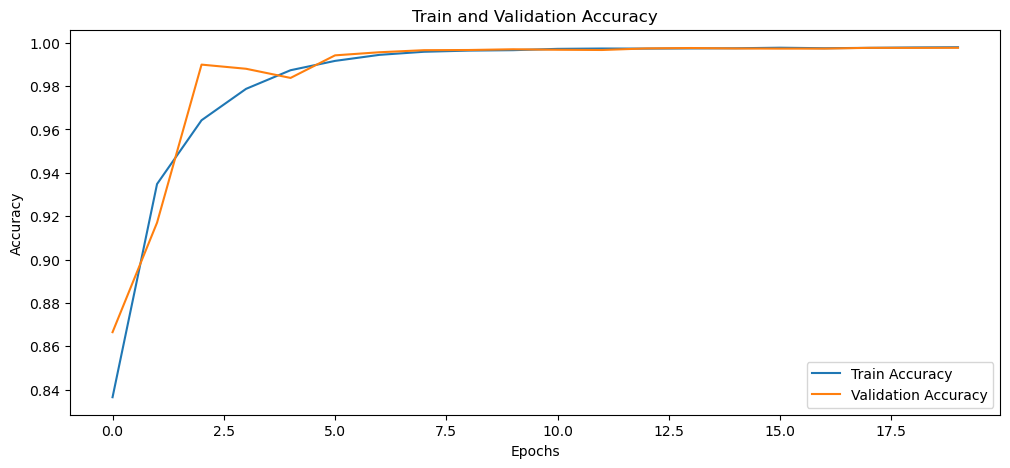

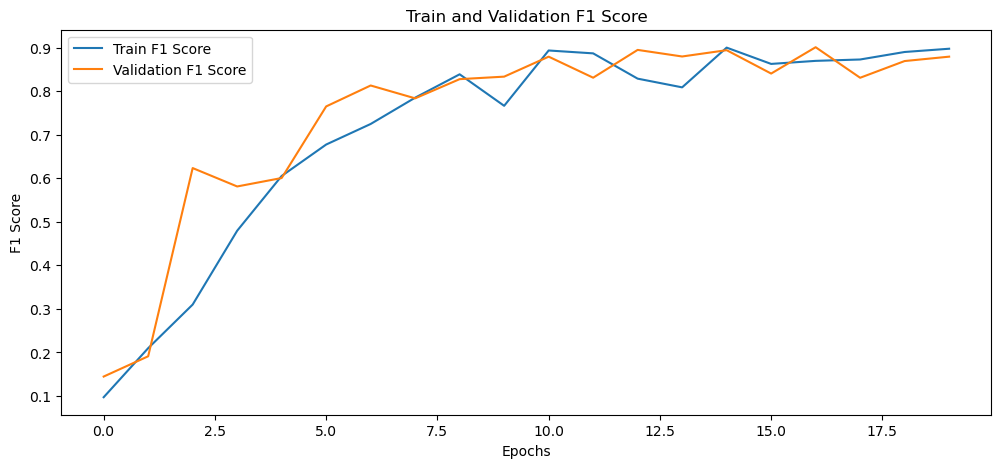

In [32]:


# Graficar y salvar la pérdida de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss')
plt.savefig('train_validation_loss.png')  # Guardar la gráfica como PNG
plt.show()

# Graficar y salvar la precisión de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy')
plt.savefig('train_validation_accuracy.png')  # Guardar la gráfica como PNG
plt.show()

# Graficar y salvar el F1 Score de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.plot(history['train_f1'], label='Train F1 Score')
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Train and Validation F1 Score')
plt.savefig('train_validation_f1_score.png')  # Guardar la gráfica como PNG
plt.show()



In [33]:
test_dataset = MRIDataset(test_images, test_masks)

# Crear los DataLoaders para entrenamiento, validación y prueba
batch_size = 32

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Imprimir información sobre el tamaño de los datasets
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")

# Verificar si los datos del dataset están correctamente definidos
assert len(test_dataset) > 0, "El dataset de prueba está vacío."


Tamaño del dataset de prueba: 1572


In [34]:
file_path = "UNet_gliomas.pth"

# Verificar si el archivo existe antes de cargarlo
if not os.path.exists(file_path):
    raise FileNotFoundError(f"No se encontró el archivo '{file_path}'. Verifica la ruta.")
else:
    model = UNet()  # Reemplaza UNet() con la clase de tu modelo
    model.load_state_dict(torch.load(file_path))
    print("Pesos cargados correctamente.")
    


Pesos cargados correctamente.


/tmp/ipykernel_295376/2024419688.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


In [35]:
from torchinfo import summary 

summary(model)

Layer (type:depth-idx)                   Param #
UNet                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       36,928
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-7                       73,856
│    └─BatchNorm2d: 2-8                  256
│    └─ReLU: 2-9                         --
│    └─Conv2d: 2-10                      147,584
│    └─BatchNorm2d: 2-11                 256
│    └─ReLU: 2-12                        --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-13                      295,168
│    └─BatchNorm2d: 2-14                 512
│    └─ReLU: 2-15                        --
│    └─Conv2d: 2-16                      590,080
│    └─BatchNorm2d: 2-17                 5

In [36]:
def evaluate_test_set(model, test_loader, device):
    model.eval()  # Switch to evaluation mode
    test_loss = 0
    all_preds = []  # Initialize the list for predictions
    all_targets = []  # Initialize the list for ground truth labels

    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing", leave=True):
            # Move data to GPU or CPU
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = dice_loss(outputs, masks)  # Use Dice loss

            test_loss += loss.item()

            # Get predictions and store them
            preds = (outputs > 0.5).float()  # Apply threshold to get binary predictions
            all_preds.extend(preds.cpu().numpy().flatten())  # Flatten to 1D array and append
            all_targets.extend(masks.cpu().numpy().flatten())  # Flatten to 1D array and append

    # Convert lists to numpy arrays and ensure they are 1D
    all_preds = np.array(all_preds).flatten()  
    all_targets = np.array(all_targets).flatten()

    # Check for NaN values in predictions or targets
    if np.any(np.isnan(all_preds)) or np.any(np.isnan(all_targets)):
        print("Error: NaN values found in predictions or labels.")
        return None

    # Calculate precision, recall, and F1 score
    try:
        test_precision = precision_score(all_targets, all_preds, average='binary')
        test_recall = recall_score(all_targets, all_preds, average='binary')
        test_f1 = f1_score(all_targets, all_preds, average='binary')

        # Print the evaluation results
        print(f"Test Loss: {test_loss / len(test_loader):.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")

        # Return metrics
        return {
            "test_loss": test_loss / len(test_loader),
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
        }

    except ValueError as e:
        print(f"Error in calculating metrics: {e}")
        return None

# Example usage:
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
# test_results = evaluate_test_set(model, test_loader, device)


In [37]:
# Set up the DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

# Move the model to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Perform evaluation
test_results = evaluate_test_set(model, test_loader, device)

# Print results
print(test_results)



Testing: 100%|████████████████████████████████| 197/197 [00:22<00:00,  8.84it/s]


Test Loss: 0.2080
Test Precision: 0.9183
Test Recall: 0.8434
Test F1 Score: 0.8793
{'test_loss': 0.2079858577190922, 'test_precision': 0.9183448897344114, 'test_recall': 0.8433830439524264, 'test_f1': 0.8792691467194959}
